In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import sys
sys.path.append('..')

In [2]:
test_indices = np.load('model_outputs/aqua_test_indices.pkl', allow_pickle=True)
test_indices

array([21112, 26516,  7351, ..., 42613, 43567, 68268])

In [3]:
aqua_modis_estimate = pd.read_pickle(f"data/LAND_aqua_transformed_modl_targets.pkl")
aqua_modis_estimate.describe()

,mTau470,mTau550,mTau660
count,7.993300e+04,7.993300e+04,7.993300e+04
mean,7.736885e-08,-9.958777e-08,-1.486824e-07
std,1.000007e+00,1.000004e+00,1.000023e+00
min,-3.762851e+00,-3.473289e+00,-3.477470e+00
25%,-6.237535e-01,-6.332772e-01,-6.301165e-01
50%,-5.014042e-03,-2.321246e-03,8.200816e-04
75%,6.264598e-01,6.368837e-01,6.461831e-01
max,4.844207e+00,4.677815e+00,4.494204e+00


In [4]:
aqua_y_test = pd.read_pickle('model_outputs/aqua_y_test.pkl')
aqua_y_test.describe()

,aTau470,aTau550,aTau660
count,7994.000000,7994.000000,7994.000000
mean,-0.010956,-0.010773,-0.010324
std,0.997682,0.997336,0.997330
min,-4.911196,-4.272670,-4.016459
25%,-0.679455,-0.677498,-0.674904
50%,-0.027695,-0.031013,-0.044363
75%,0.658277,0.661785,0.662257
max,3.584526,3.536623,3.440003


In [5]:
aqua_mlp_out = pd.read_pickle('model_outputs/aqua_mlp_out.pkl')
aqua_mlp_out.describe()

,aTau470,aTau550,aTau660
count,7994.000000,7994.000000,7994.000000
mean,0.017246,0.016615,0.018009
std,0.898444,0.894053,0.884951
min,-3.449356,-3.419954,-3.305180
25%,-0.605856,-0.601663,-0.596905
50%,-0.071074,-0.070844,-0.076258
75%,0.594463,0.596871,0.591760
max,3.486329,3.599880,3.745518


In [6]:
aqua_edl_out_np = np.load('model_outputs/aqua_edl_out_edl_param=0.1.npy')
aqua_mu, aqua_v, aqua_alpha, aqua_beta = tf.split(aqua_edl_out_np, [aqua_mlp_out.shape[1] for i in range(4)], axis=-1)
aqua_var = np.sqrt(aqua_beta / (aqua_v * (aqua_alpha - 1)))
aqua_edl_out = pd.DataFrame(aqua_mu.numpy(), columns=aqua_mlp_out.columns)

2022-03-07 01:47:03.950268: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
from kde import calc_kde2d
from aod_models import plot_kde2d, plot_linregress, plot_linregress_diff

Starting the 2D kernel density estimation with 7994 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


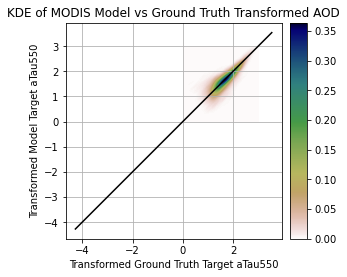

In [8]:
transformed_y_test = aqua_y_test.aTau550
transformed_modis_y_test_aod = aqua_modis_estimate.iloc[test_indices].mTau550
y_test_bins, out_bins_modis, P_modis = calc_kde2d(transformed_y_test, transformed_modis_y_test_aod)
plot_kde2d(y_test_bins, out_bins_modis, P_modis, x_bounds=[0,3], y_bounds=[0,3], Title='KDE of MODIS Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 7994 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


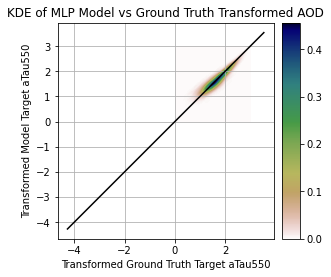

In [9]:
transformed_y_test = aqua_y_test.aTau550
transformed_out_df = aqua_mlp_out.aTau550
y_test_bins, out_bins, P = calc_kde2d(transformed_y_test, transformed_out_df)
plot_kde2d(y_test_bins, out_bins, P, Title='KDE of MLP Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

Starting the 2D kernel density estimation with 7994 data points...
Evaluating 2D kernel on grid with (Nx,Ny)=(256,256) ...
X, Y, P shapes:  (256, 256) (256, 256) (256, 256)


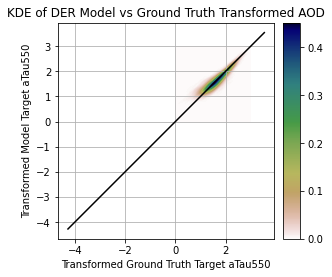

In [10]:
transformed_y_test = aqua_y_test.aTau550
transformed_out_edl_df = aqua_edl_out.aTau550
y_test_bins, out_edl_bins, P_edl = calc_kde2d(transformed_y_test, transformed_out_edl_df)
plot_kde2d(y_test_bins, out_edl_bins, P_edl, Title='KDE of DER Model vs Ground Truth Transformed AOD', xLabel='Transformed Ground Truth Target aTau550', yLabel='Transformed Model Target aTau550')

0.8064615070016057 -0.009424125421123846 0.8024305234271537 0.0 0.006708688953582402
0.8024305234271537


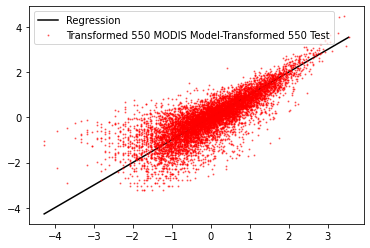

In [11]:
# MODIS lin reg
r = plot_linregress(transformed_y_test, transformed_modis_y_test_aod, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MODIS Model-Transformed 550 Test')
print(r)

0.8105700211398332 0.025347124455426702 0.9042110542830591 0.0 0.004282607027054544
0.9042110542830591


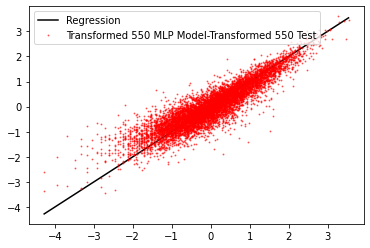

In [12]:
# MLP lin reg
r = plot_linregress(transformed_y_test, transformed_out_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 MLP Model-Transformed 550 Test')
print(r)

0.7950407886048977 -0.006761720680996194 0.9001418569152781 0.0 0.004303635397112735
0.9001418569152781


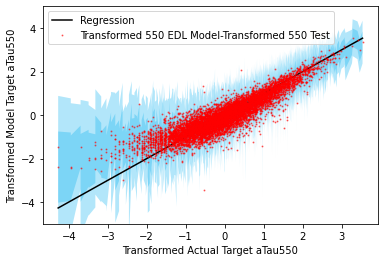

In [13]:
# EDL lin reg
n_stds = 4
std = np.minimum(np.sqrt(aqua_var), 1e3)
r = plot_linregress(transformed_y_test, transformed_out_edl_df, np.linspace(transformed_y_test.min(), transformed_y_test.max()), 'Transformed 550 EDL Model-Transformed 550 Test')
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1]), (transformed_out_edl_df[indices] + std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1]), (transformed_out_edl_df[indices] + 2*std[indices][:,1]),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Actual Target aTau550')
plt.ylabel('Transformed Model Target aTau550')
plt.ylim([-5,5])
print(r)

0.7950407886048977 -0.006761720680996194 0.9001418569152781 0.0 0.004303635397112735
[-0.70691776  0.80826914  0.01656508 ...  0.70256543  0.4626841
  0.5729946 ]
0.9001418569152781


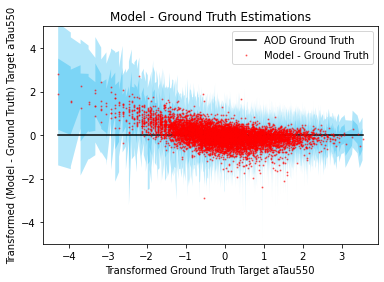

In [14]:
n_stds = 4
std = np.minimum(np.sqrt(aqua_var), 1e3)
r = plot_linregress_diff(transformed_y_test.values, transformed_out_edl_df.values, np.linspace(transformed_y_test.min(), transformed_y_test.max()))
indices = np.argsort(transformed_y_test)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.fill_between(
    transformed_y_test[indices], (transformed_out_edl_df[indices] - 2*std[indices][:,1] - transformed_y_test[indices].values), (transformed_out_edl_df[indices] + 2*std[indices][:,1] - transformed_y_test[indices].values),
    alpha=0.3,
    edgecolor=None,
    facecolor='#00aeef',
    linewidth=0,
    zorder=1)
plt.xlabel('Transformed Ground Truth Target aTau550')
plt.ylabel('Transformed (Model - Ground Truth) Target aTau550')
plt.legend(loc='best')
plt.ylim([-5,5])
print(r)

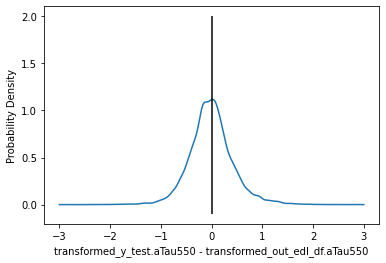

In [19]:
from sklearn.neighbors import KernelDensity
diff_transformed_aod_estimations = transformed_out_edl_df.to_numpy() - transformed_y_test.to_numpy()
kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(diff_transformed_aod_estimations[:, np.newaxis])
X_plot = np.linspace(-3, 3, 1000)[:, np.newaxis]
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))
plt.xlabel('transformed_y_test.aTau550 - transformed_out_edl_df.aTau550')
plt.ylabel('Probability Density')
plt.vlines(0, ymin=-0.1, ymax=2, color='k')